In [1]:
import pandas as pd
import numpy as np
import math
from matplotlib import pyplot as plt
import os
import sys
import pickle
# Add the function directory to the path
# sys.path.append('/home/jiarong/research/postprocessing/jupyter_notebook/functions/')
sys.path.append('/projects/DEIKE/jiarongw/jiarongw-postprocessing/jupyter_notebook/functions/')
from fio import readin
from tqdm import tqdm
from visualization import contour_generator

In [7]:
'''
    Initialization based on PM/JONSWAP.
    F_kmod = P*kmod**(-2.5)*np.exp(-1.25*(kp/kmod)**2) (the exponential factor was 0.74 in original PM)
    All identities with _tile are two-dimensional array.
    In principle kmax = 2*np.pi/(2L/N_grid), kmin=2*np.pi/L.
''' 
# Function to convert polar to cartesian and interpolate
def cart2pol(x, y):
    rho = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    return(rho, phi)
def pol2cart(rho, phi):
    x = rho * np.cos(phi)
    y = rho * np.sin(phi)
    return(x, y)

from scipy.interpolate import LinearNDInterpolator, griddata
def spectrum_gen(kp=2*np.pi/100, P=0.45, L=500, N_power=5):
    thetam = 0
    N_mode = 32; # Uniform grid in kx and ky : how many we want to put in the initialization
    N_kmod = 64; N_theta = 64 # Uniform grid in kmod and ktheta
    kmod = np.linspace(2*np.pi/L,1.5*N_mode*2*np.pi/L,N_kmod); theta = np.linspace(-0.5*np.pi, 0.5*np.pi, N_theta)
    kmod_tile, theta_tile = np.meshgrid(kmod,theta)
    """ JONSWAP without shape modification gamma """
    F_kmod = P*kmod**(-2.5)*np.exp(-1.25*(kp/kmod)**2)
    D_theta = np.cos(theta-thetam)**N_power
    dtheta = theta[1]-theta[0]
    """ Is this necessary? Yes! """
    D_theta = D_theta/np.trapz(D_theta, theta)  # Normalize so the sum equals one
    F_kmod_tile, D_theta_tile = np.meshgrid(F_kmod,D_theta) 
    F_kmodtheta_tile = F_kmod_tile*D_theta_tile/kmod_tile # Notice!! Normalize by k
    """ Uniform grid in kx,ky """
    kx = np.arange(1,N_mode+1)*2*np.pi/L # based on the grid, interval can't go smaller then pi/L
    ky = np.arange(-N_mode/2,N_mode/2+1)*2*np.pi/L
    kx_tile, ky_tile = np.meshgrid(kx,ky)
    kxp_tile, kyp_tile = pol2cart(kmod_tile, theta_tile)
    """ Project from uniform k to uniform kx,ky """
    F_kxky_tile = griddata((kxp_tile.ravel(), kyp_tile.ravel()), F_kmodtheta_tile.ravel(), (kx_tile, ky_tile), 
                            method='linear', fill_value=0) # Interpolate from kxp,kyp (uniform in k) to kx,ky (uniform in kx,ky)
    return kmod, F_kmod, kx, ky, F_kxky_tile

Text(0.5, 0, 'kx')

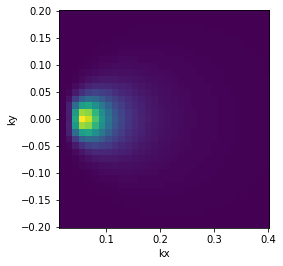

In [22]:
# Spectrum for L0 = 500
kp = 2*np.pi/100 # peak at 100m
P = 0.08 # Amplitude that needs to be tuned
kmod, F_kmod, kx, ky, F_kxky_tile = spectrum_gen(kp, P, L=500)
kx_tile, ky_tile = np.meshgrid(kx,ky)
# Some visualization:
# plt.plot(kmod, F_kmod, '.')
# plt.ylabel('F(k)'); plt.xlabel('k')
plt.imshow(F_kxky_tile, extent=[kx_tile[0,0],kx_tile[-1,-1],ky_tile[0,0],ky_tile[-1,-1]])
plt.ylabel('ky'); plt.xlabel('kx')

Text(0.5, 0, 'kx')

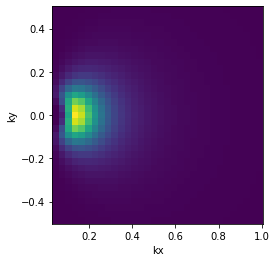

In [16]:
# Spectrum for L0 = 200
kp = 2*np.pi/40 # peak at 40m
P = 0.01
kmod, F_kmod, kx, ky, F_kxky_tile = spectrum_gen(kp, P, L=200, N_power=2)
kx_tile, ky_tile = np.meshgrid(kx,ky)
# Some visualization:
# plt.plot(kmod, F_kmod, '.')
# plt.ylabel('F(k)'); plt.xlabel('k')
plt.imshow(F_kxky_tile, extent=[kx_tile[0,0],kx_tile[-1,-1],ky_tile[0,0],ky_tile[-1,-1]])
plt.ylabel('ky'); plt.xlabel('kx')

In [ ]:
# Spectrum for L0 = 50
kp = 2*np.pi/10 # peak at 10m
P = 0.002
kmod, F_kmod, kx, ky, F_kxky_tile = spectrum_gen(kp, P, L=50)
kx_tile, ky_tile = np.meshgrid(kx,ky)
# Some visualization:
# plt.plot(kmod, F_kmod, '.')
# plt.ylabel('F(k)'); plt.xlabel('k')
plt.imshow(F_kxky_tile, extent=[kx_tile[0,0],kx_tile[-1,-1],ky_tile[0,0],ky_tile[-1,-1]])
plt.ylabel('ky'); plt.xlabel('kx')

In [106]:
# Output F_kxky 50m case
fF = open("/projects/DEIKE/jiarongw/multilayer/F_kxky_P0.005_50m", 'bw')
F_output = F_kxky_tile.astype('float32'); F_output.tofile(fF)
F_kxky_tile.shape

(33, 32)

In [25]:
fF1 = open("/projects/DEIKE/jiarongw/multilayer/kx_50m", 'bw')
F_output = kx.astype('float32'); F_output.tofile(fF1)
fF2 = open("/projects/DEIKE/jiarongw/multilayer/ky_50m", 'bw')
F_output = ky.astype('float32'); F_output.tofile(fF2)

In [17]:
# Output F_kxky 200m case
fF = open("/projects/DEIKE/jiarongw/multilayer/F_kxky_P0.01_200m_N2", 'bw')
F_output = F_kxky_tile.astype('float32'); F_output.tofile(fF)
F_kxky_tile.shape

(33, 32)

In [21]:
fF1 = open("/projects/DEIKE/jiarongw/multilayer/kx_200m", 'bw')
F_output = kx.astype('float32'); F_output.tofile(fF1)
fF2 = open("/projects/DEIKE/jiarongw/multilayer/ky_200m", 'bw')
F_output = ky.astype('float32'); F_output.tofile(fF2)

In [71]:
# Output F_kxky 500m case
fF = open("/projects/DEIKE/jiarongw/multilayer/F_kxky_P0.08_500m", 'bw')
F_output = F_kxky_tile.astype('float32'); F_output.tofile(fF)
F_kxky_tile.shape

(33, 32)

In [23]:
fF1 = open("/projects/DEIKE/jiarongw/multilayer/kx_500m", 'bw')
F_output = kx.astype('float32'); F_output.tofile(fF1)
fF2 = open("/projects/DEIKE/jiarongw/multilayer/ky_500m", 'bw')
F_output = ky.astype('float32'); F_output.tofile(fF2)

In [5]:
'''
    Add modes together to generate initial eta field. Random phase.
'''

def eta_random(t, N_grid, kx_tile, ky_tile, F_kxky_tile, dkx, dky, omega_tile):
    # This is the only place that the random field is generated, everything else should agree;
    # and we want to seed the random number
    np.random.seed(0) 
    tb = 40; xb = 0; yb = 0
    phase_tile = -kx_tile*xb-ky_tile*yb+np.random.random_sample(kx_tile.shape)*2*np.pi # Add a random phase field
    #phase_tile = -kx_tile*xb-ky_tile*yb+omega_tile*tb+np.random.random_sample(kx_tile.shape)*5 # Add a random phase field
    eta_tile = np.zeros(x_tile.shape)
    for i1 in range(0,N_grid):
        for i2 in range(0,N_grid):
            ampl = (2*F_kxky_tile*dkx*dky)**0.5
            # How to exactly represent integrate over dk_x*dk_y*eta_hat?
            # mode = (F_kdirectional**0.5)*np.cos((kx_tile*x_tile[i1,i2]+ky_tile*y_tile[i1,i2])+
            #                                    phase_tile)*(kmod_tile*(kmod[1]-kmod[0])*(theta[1]-theta[0])) # uniform space in k and theta
            a = (kx_tile*x_tile[i1,i2]+ky_tile*y_tile[i1,i2])-omega_tile*t+phase_tile
            mode = ampl*(np.cos(a)) # uniform spacing in kx and ky
            eta_tile[i1,i2] = np.sum(mode)    
    return eta_tile, phase_tile

In [81]:
''' Check kp*Hs, 50m '''

kp = 2*np.pi/10 # peak at 10m
P = 0.015
kmod, F_kmod, kx, ky, F_kxky_tile = spectrum_gen(kp, P, L=50)
kx_tile, ky_tile = np.meshgrid(kx,ky)

N_grid = 256; L = 50
x = np.linspace(-L/2,L/2,N_grid); y = np.linspace(-L/2,L/2,N_grid)
x_tile, y_tile = np.meshgrid(x, y)
kmod_cart_tile, theta_cart_tile = cart2pol(kx_tile,ky_tile)
omega_tile = (9.8*kmod_cart_tile)**0.5 # frequency based on kx or kmod
dkx = kx_tile[0,1]-kx_tile[0,0]; dky = ky_tile[1,0]-ky_tile[0,0]

eta_tile, phase_tile = eta_random(0, N_grid, kx_tile, ky_tile, F_kxky_tile, dkx, dky, omega_tile)
kpHs = np.var(eta_tile)**0.5*kp*4
print('kp*Hs = %g' %kpHs)
# We don't need to output eta anymore cuz the initialization is taken care in Basilisk already
# feta = open("/home/jiarong/research/projects/multilayer/testing/randfocusing_P0010_layer60_newremap/readin/pre/eta", 'bw')
# eta_output = eta_tile.astype('float32'); eta_output.tofile(feta)

kp*Hs = 0.301395


In [15]:
''' Check kp*Hs, 200m '''

kp = 2*np.pi/40 # peak at 40m
P = 0.01
kmod, F_kmod, kx, ky, F_kxky_tile = spectrum_gen(kp, P, L=200)
kx_tile, ky_tile = np.meshgrid(kx,ky)

N_grid = 256; L = 200
x = np.linspace(-L/2,L/2,N_grid); y = np.linspace(-L/2,L/2,N_grid)
x_tile, y_tile = np.meshgrid(x, y)
kmod_cart_tile, theta_cart_tile = cart2pol(kx_tile,ky_tile)
omega_tile = (9.8*kmod_cart_tile)**0.5 # frequency based on kx or kmod
dkx = kx_tile[0,1]-kx_tile[0,0]; dky = ky_tile[1,0]-ky_tile[0,0]

eta_tile, phase_tile = eta_random(0, N_grid, kx_tile, ky_tile, F_kxky_tile, dkx, dky, omega_tile)
kpHs = np.var(eta_tile)**0.5*kp*4
print('kp*Hs = %g' %kpHs)
# We don't need to output eta anymore cuz the initialization is taken care in Basilisk already
# feta = open("/home/jiarong/research/projects/multilayer/testing/randfocusing_P0010_layer60_newremap/readin/pre/eta", 'bw')
# eta_output = eta_tile.astype('float32'); eta_output.tofile(feta)

kp*Hs = 0.174011


In [73]:
''' Check kp*Hs, 500m '''

kp = 2*np.pi/100 # peak at 10m
P = 0.08
kmod, F_kmod, kx, ky, F_kxky_tile = spectrum_gen(kp, P, L=500)
kx_tile, ky_tile = np.meshgrid(kx,ky)

N_grid = 256; L = 500
x = np.linspace(-L/2,L/2,N_grid); y = np.linspace(-L/2,L/2,N_grid)
x_tile, y_tile = np.meshgrid(x, y)
kmod_cart_tile, theta_cart_tile = cart2pol(kx_tile,ky_tile)
omega_tile = (9.8*kmod_cart_tile)**0.5 # frequency based on kx or kmod
dkx = kx_tile[0,1]-kx_tile[0,0]; dky = ky_tile[1,0]-ky_tile[0,0]

eta_tile, phase_tile = eta_random(0, N_grid, kx_tile, ky_tile, F_kxky_tile, dkx, dky, omega_tile)
kpHs = np.var(eta_tile)**0.5*kp*4
print('kp*Hs = %g' %kpHs)
# We don't need to output eta anymore cuz the initialization is taken care in Basilisk already
# feta = open("/home/jiarong/research/projects/multilayer/testing/randfocusing_P0010_layer60_newremap/readin/pre/eta", 'bw')
# eta_output = eta_tile.astype('float32'); eta_output.tofile(feta)

kp*Hs = 0.391331


In [202]:
'''
    Add modes together to generate initial eta field.
    Phase not random but focusing.
'''
def eta_focusing(t):
    global N_grid, kx_tile, ky_tile, F_kxky_tile, dkx, dky, omega_title
    tb = 40; xb = 0; yb = 0 # travelling at group velocity?
    phase_tile = -kx_tile*xb-ky_tile*yb+omega_tile*tb
    # phase_tile = np.random.random_sample(kx_tile.shape)*2*np.pi # Add a random phase field
    # x = np.linspace(-L/2,L/2+L/N_grid,N_grid+1,endpoint=False)+L/N_grid/2; y = np.linspace(-L/2,L/2,N_grid,endpoint=False)+L/N_grid/2
    x = np.linspace(-L/2,L/2,N_grid,endpoint=False)+L/N_grid/2 # So that interpolation does not have nan
    y = np.linspace(-L/2,L/2,N_grid,endpoint=False)+L/N_grid/2
    x_tile, y_tile = np.meshgrid(x, y)
    eta_tile = np.zeros(x_tile.shape)
    for i1 in range(0,N_grid):
        for i2 in range(0,N_grid):
            ampl = (2*F_kxky_tile*dkx*dky)**0.5
            a = (kx_tile*x_tile[i1,i2]+ky_tile*y_tile[i1,i2])-omega_tile*t+phase_tile
            mode = ampl*(np.cos(a)) # uniform space in kx and ky
            eta_tile[i1,i2] = np.sum(mode)  
    return eta_tile,phase_tile

In [ ]:
# How to speed up matplotlib
# https://stackoverflow.com/questions/8955869/why-is-plotting-with-matplotlib-so-slow
from matplotlib import animation
from visualization import contour
from IPython.display import HTML
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.colors as mcolors
import matplotlib.image as mpimg

# Single animation generation function
def plot_animation(animate_function, frame_number = 31, interval_time = 100):

    # First set up the figure, the axis, and the plot element we want to animate    
    fig,ax = contour_generator()
    pcontour = ax[0].imshow(eta_tile*kp, vmax=0.2, vmin=-0.2)
    ax[0].cax.colorbar(pcontour)

    # animation function.  This is called sequentially
    def animate(i):
        t = i*2
        imgplot = animate_function(i, ax[0])
        return imgplot,

    # call the animator.  blit=True means only re-draw the parts that have changed.
    anim = animation.FuncAnimation(fig, animate, frames=frame_number, interval=interval_time, blit = True)  
    return anim

# Define the function called at every animation time to read in images
def plot_func(i, ax):
    t = i
    eta_tile = eta_random(t)
    image = ax.imshow(eta_tile*kp, vmax=0.2, vmin=-0.2)
    return image

anim = plot_animation(plot_func, frame_number = 100, interval_time = 100) # Specify frame number
HTML(anim.to_html5_video())

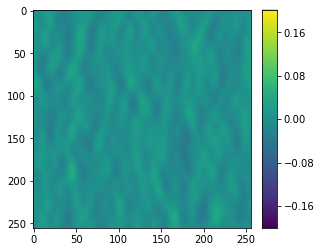

In [47]:
fig,grid = contour_generator()
eta_tile,phase_tile = eta_random(0)
pcontour = grid[0].imshow(eta_tile*kp, vmax=0.2, vmin=-0.2)
grid[0].cax.colorbar(pcontour)

In [48]:
'''
    Check that calculation of F(kmod) is consistent by comparing integration of F(kmod) and mean square
    of the initial eta field.
'''
dx = L/N_grid
F_integrated = np.sum(F_kxky_tile)*((kx_tile[0,1]-kx_tile[0,0])*(ky_tile[1,0]-ky_tile[0,0])) # Integration over kx ky is easier
print(F_integrated)
print(np.sum((eta_tile-np.average(eta_tile))**2)/(L**2)*dx*dx)# Notice the Delta x normalization
print(np.std(eta_tile)*kp)
print(np.average(eta_tile))
print(np.max(eta_tile)*kp)
print(np.sum((eta_tile-np.average(eta_tile))**2)*dx**2*9.8)

0.042586669600134894
0.04253652812162283
0.01295868365469626
0.00047241281262012464
0.04242064316600821
104214.49389797593


In [139]:
'''k
    Output eta to file
'''
eta_tile,phase_tile = eta_random(0)
feta = open("/home/jiarong/research/projects/multilayer/testing/randfocusing_P0010_layer60_newremap/readin/pre/eta", 'bw')
eta_output = eta_tile.astype('float32'); eta_output.tofile(feta)

In [138]:
'''
    A second way of initializing velocity. Adding an actual z option. 
'''
eta_tile, phase_tile = eta_random(0)
zb = -5; z_tile = zb*np.ones(x_tile.shape) # computational domain bottom position
N_layer = 60 # Number of layers used 
h_tile = eta_tile/N_layer # height of each layer (uniformly divided)
g = 9.8
u_tile = np.zeros(x_tile.shape); v_tile = np.zeros(x_tile.shape); w_tile = np.zeros(x_tile.shape)
u_set = []; v_set = []; w_set = []; z_set=[] # For sanity checks
kmod_cart_tile, theta_cart_tile = cart2pol(kx_tile,ky_tile) # The module of k from kx_tile and ky_tile
for l in tqdm(range(0, N_layer)):
    u_tile, v_tile, w_tile = np.zeros(x_tile.shape), np.zeros(x_tile.shape), np.zeros(x_tile.shape)
    z_tile = z_tile + (eta_tile-zb)/N_layer/2
    for i1 in range(0,N_grid):
        for i2 in range(0,N_grid):
            ampl = (2*F_kxky_tile*dkx*dky)**0.5
            actual_z_tile = np.minimum(ampl, np.ones(ampl.shape)*z_tile[i1,i2]) # Element wise comparison
            a = (kx_tile*x_tile[i1,i2]+ky_tile*y_tile[i1,i2])+phase_tile
            mode = ampl*(np.cos(a))
            # u = \sqrt{gk}*A*sin(kx-wt), but also need to consider direction cos(theta)
            u_mode = (g*kmod_cart_tile)**0.5*ampl*np.exp(kmod_cart_tile*actual_z_tile)*np.cos(a)*np.cos(theta_cart_tile)
            v_mode = (g*kmod_cart_tile)**0.5*ampl*np.exp(kmod_cart_tile*actual_z_tile)*np.cos(a)*np.sin(theta_cart_tile)
            w_mode = (g*kmod_cart_tile)**0.5*ampl*np.exp(kmod_cart_tile*actual_z_tile)*np.sin(a)
            u_tile[i1,i2] = np.sum(u_mode); v_tile[i1,i2] = np.sum(v_mode); w_tile[i1,i2] = np.sum(w_mode)
    u_set.append(u_tile); v_set.append(v_tile); w_set.append(w_tile); z_set.append(z_tile)
    fu = open("/home/jiarong/research/projects/multilayer/testing/randfocusing_P0010_layer60_newremap/readin/pre/u_layer%g" %l, "bw")
    u_output = u_tile.astype('float32'); u_output.tofile(fu)
    fv = open("/home/jiarong/research/projects/multilayer/testing/randfocusing_P0010_layer60_newremap/readin/pre/v_layer%g" %l, "bw")
    v_output = v_tile.astype('float32'); v_output.tofile(fv)
    fw = open("/home/jiarong/research/projects/multilayer/testing/randfocusing_P0010_layer60_newremap/readin/pre/w_layer%g" %l, "bw")
    w_output = w_tile.astype('float32'); w_output.tofile(fw)
    z_tile = z_tile + (eta_tile-zb)/N_layer/2

100%|██████████| 60/60 [05:33<00:00,  5.59s/it]


In [ ]:
'''
    Check KE and GPE equal partition.
'''
# To do: compute gpe from z_set
# Energy/area

gpe = 0.5*np.sum(eta_tile**2)*(1/(N_grid*RATIO))**2*9.8
print(gpe)
ke = 0
gpe_int = 0
for ilayer in range(0,N_layer):
    # Kinetic energy is integrated along the depth thus zb/N_layer
    ke += (np.sum(u_set[ilayer]**2)+np.sum(v_set[ilayer]**2)+np.sum(w_set[ilayer]**2))*(1/(N_grid*RATIO))**2*(0-zb)/N_layer
    gpe_int += np.sum(z_set[ilayer])*(1/(N_grid*RATIO))**2*(0-zb)/N_layer
ke = 0.5*ke
print(ke)
gpe_baseline = 0.5*zb**2
print((gpe_int-gpe_baseline)*9.8)

In [ ]:
'''
    Plot the initial F(kmod).
    Check shape and peak.
'''
L = 50; N = 256; i=0
spectrum = np.fft.fft2(eta_tile_higher)*(1/N)**2 # How to normalize here?!
F = np.absolute(spectrum)
F_center = np.fft.fftshift(F)
wavenumber = 2*np.pi*np.fft.fftfreq(n=N,d=L/N)
kx = np.fft.fftshift(wavenumber)
ky = kx
kx_tile, ky_tile = np.meshgrid(kx,ky)
theta = np.arange(-N/4,N/4)/(N)*2*np.pi
k = wavenumber[0:int(N/2)]
k_tile, theta_tile = np.meshgrid(k,theta)
kxp_tile, kyp_tile = pol2cart(k_tile, theta_tile)
from scipy import interpolate
f = interpolate.RectBivariateSpline(kx, ky, F_center)
F_center_polar = f.ev(kxp_tile, kyp_tile)
F_center_polar_integrated = np.sum(F_center_polar, axis=0)*(theta[1]-theta[0])*k
plt.plot(k[0:int(N/2)],F_center_polar_integrated*2, color=plt.cm.get_cmap('summer')(i/18), label='t=%g' %i)

In [ ]:
# Remaining problem
# 1. "ampl = (2*F_kxky_tile*dkx*dky)**0.5" dxdy inside!
# 2. When integrate to get \eta^2. Why "*dx/L*dy/L"? I think I got that now!
# 3. In the velocity initialization, some tricks.
# Luc's code
# wave2dint=nansum(nansum(wave2d.^2))*dx*dx./L./L
# waveintafterfft3=nanstd(wave3).^2;
# waveintback=nansum(S2(1:N/2))*dk1%yeah!